In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


from astropy import constants as const
from astropy import units as u


from scipy.optimize import curve_fit

from galaxy_analysis.plot.plot_styles import *
def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return



In [8]:

class FitData:
    
    def __init__(self, x, y, logx=True, logy=True):
        """
        Class to simplify fitting polynomials to the datatsets
        """
        
        self.x = x
        self.y = y
        
        self.logx=logx
        self.logy=logy
        
        if self.logx:
            self._fitx = np.log10(x)
        else:
            self._fitx = 1.0*self.x
            
        if self.logy:
            self._fity = np.log10(y)
        else:
            self._fity = 1.0*self.y
        
        
        self.params = None
        
        return
    
    def generate_polyfit(self, deg = 2, cut = None):
        """
        Generate polynomial fits of specified degree. If 
        cut is provided, splits data x domain at that cut value
        and fits multiple polynomials. Multiple cuts can be provided
        as a list, and N_cut+1 fits will be made.
        """
                
        if cut is None:
            self.deg    = [deg]
            self.cut    = None
            self.params = [np.polyfit(self._fitx, self._fity, deg = self.deg[0])]
            
        else:
            
            if np.size(cut) == 1:
                self.deg = [deg,deg]
                self.cut = [cut]
            else:
                if np.size(deg) == 1:
                    self.deg = [deg] * (np.size(cut)+1)
                else:
                    self.deg = deg
                self.cut = cut
                            
            cutmin = np.min(self.x)
            cutmax = self.cut[0]
            
            self.params = [None]*(np.size(self.cut)+1)
            
            for i in np.arange(np.size(self.cut)+1):
                
                select = (self.x>=cutmin) * (self.x < cutmax)
                
                self.params[i] = np.polyfit(self._fitx[select], 
                                            self._fity[select], deg=self.deg[i])
                
                cutmin = cutmax*1.0
                
                if i >= (np.size(self.cut) - 1):
                    cutmax = np.max(self.x)*1.0001
                else:
                    cutmax = self.cut[i+1]
                    
        
        self.error    = (self.y - self.evaluate(self.x)) / self.y
        self.abserror = np.abs(self.error)
        
        self.maxerror     = np.max(self.abserror)
        self.avgerror     = np.average(self.abserror)
        
        return
    
    def evaluate(self, xvals):
        """
        Once fit, evaluate
        """
        
        if self.params is None:
            print("No fit made yet")
            raise RuntimeError
        
        result = np.zeros(np.size(xvals))
        
        if self.logx:
            result_x = np.log10(xvals)
        else:
            result_x = 1.0*xvals
        
        if self.cut is None:
            for i,c in enumerate(self.params[0]):
                result += c * result_x**(self.deg[0]-i)
        else:
            
            cutmin = np.min( [np.min(self.x),np.min(xvals)])
            cutmax = self.cut[0]
            
            for j in np.arange(len(self.cut)+1):
                
                select = (xvals>=cutmin)*(xvals<cutmax)
                
                for i,c in enumerate(self.params[j]):
            
                    result[select] += c * result_x[select]**(self.deg[0]-i)
                
                
                cutmin = 1.0*cutmax
                if j >= len(self.cut) - 1:
                    cutmax = np.max(self.x)*1.0001
                else:
                    cutmax = self.cut[j+1]                
        
        return 10.0**result
    
    
    def output_to_code(self, fit_only = None, end='\n'):
        """
        print out polynomial fit(s) in a way that can be copy-pasted
        to c++
        """
        
        if fit_only is None:
            print("%i polynomial fits made"%(len(self.params)))
        
            if not (self.cut is None):
                cutmin = np.min(self.x)
                cutmax = self.cut[0]        
            
                for i in np.arange(np.size(self.cut)+1):
                    print("%i degree over the range %5.5E <= x < %5.5E"%(self.deg[i],cutmin,cutmax))
                
                    cutmin = cutmax*1.0
                
                    if i >= (np.size(self.cut) - 1):
                        cutmax = np.max(self.x)*1.0001
                    else:
                        cutmax = self.cut[i+1]
        
            output_params = self.params
        else:
            output_params = [self.params[fit_only]]
        
        
        for j, p in enumerate(output_params):
            if self.logy:
                print("= pow(10.0, ",end='')
            else:
                print("= (",end='')
                
            for i, c in enumerate(p):
                
                if self.deg[j]-i == 0:
                    print(" %5.4e"%(c),end='')
                elif self.deg[j]-i == 1:
                    print(" %5.4e*x"%(c), end = '')                    
                else:
                    print(" %5.4e*x%i"%(c, self.deg[j]-i), end = '')
                
                if i < np.size(p) - 1:
                    if p[i+1] > 0:
                        print(" +",end='')
                
                    
            print(");",end=end)
            
        return
    


In [14]:
def JW_J21(z):
    #
    # Fit from Wise+2012 model
    #
    
    J21 = 10.0**(-2.356 + 0.45620 * z - 0.02680*z*z + 5.882E-4*z*z*z + - 5.056E-6 * z*z*z*z)
    
    return J21
    

In [59]:
#
# Load and generate fit to Qin+2020 data 
#

QinData = np.genfromtxt("Qin2020_LW_Fig5.dat",names=True,skip_header=7)
QinFit = FitData(Qindata['z'][::-1], QinData['J_LW'][::-1],logx=False,logy=True)
QinFit.generate_polyfit(deg=3)

In [60]:
JW_J21(20)

0.8803188472197567

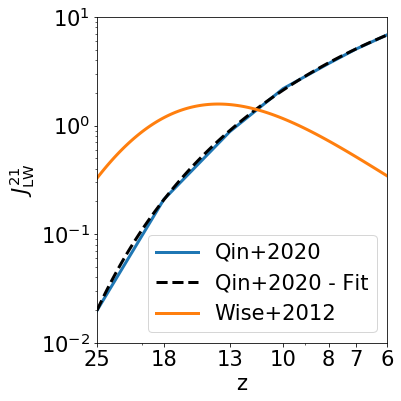

In [63]:
plot_settings()
from matplotlib.ticker import NullFormatter


fig,ax = plt.subplots()
fig.set_size_inches(6,6)


z = np.linspace(25,6,100)

ax.plot(QinData['z'], QinData['J_LW'], lw = 3, color = 'C0', ls = '-', label = 'Qin+2020')
ax.plot(z, QinFit.evaluate(z), lw = 3, color = 'black', ls = '--', label = 'Qin+2020 - Fit')
ax.plot(z, JW_J21(z), lw = 3, label = "Wise+2012",color = 'C1')


ax.set_ylabel(r"$J^{21}_{\rm LW}$")
ax.set_xlabel("z")

ax.set_xlim(25,6)
ax.legend(loc='best')


ax.semilogy()
ax.semilogx()

ax.set_ylim(0.01,10.0)
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_xticks([25,18,13,10,8,7,6])
ax.set_xticklabels([25,18,13,10,8,7,6])

plt.tight_layout()

fig.savefig("J_21_comparison.png")


In [62]:
QinFit.output_to_code()

1 polynomial fits made
= pow(10.0,  -6.8115e-05*x3 + 2.3357e-03*x2 -1.5068e-01*x + 1.6685e+00);
